<a href="https://colab.research.google.com/github/daniribeirof/UB_DS-ML_4_Text-Classification-NLP/blob/main/Project4_Text_Classification_NLP_Daniela_Ribeiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification


In this lab you are going to train several deep learning models for text classification. As you know, the goal of text classification is given a piece of text and a label, learning a model that is able to predict labels from text.

Take for example a simple **Sentiment Analysis** problem. For this problem let's consider texts that belong to movie reviews. **These reviews can be classified on positive or negative**.

First, we are going to import and install some of the libraries we will need.

In [ ]:
# We import the libraries that we are going to use
import os
import shutil
import string
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import spacy
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm_notebook
import time
from sklearn import metrics
import time

In [ ]:
# workaround for solving UTF-8 error of colab
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# Library to make visualisation of word embeddings
!pip install whatlies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 44.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.6 MB/s eta 0:00:00
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=26527929 sha256=304f9b0b2d0125af622cf96aff4c20c1629db8273cdea63181987f1a12c89052
  Stored in directory: /root/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1


Here we download the language model from Spacy that we are going to use.

In [ ]:
# Mind the ! sign at the beginning of the command that indicates that it belongs to a command line call.
! python -m spacy download en_core_web_lg #en=english

2023-04-14 16:38:52.226689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


## Dataset

We download the IMDB dataset from the web page with the `wget` command line tool. The IMDB dataset includes 50K movie reviews for natural language processing or text analytics. This is a dataset for binary sentiment classification, which includes a set of 25,000 movie reviews for training and 25,000 for testing.

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xzf aclImdb_v1.tar.gz
!ls aclImdb/

# remove unnecessary files from the dataset
shutil.rmtree('aclImdb/train/unsup')

--2023-04-14 16:39:30--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  35.2MB/s    in 2.3s    

2023-04-14 16:39:33 (35.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

imdbEr.txt  imdb.vocab	README	test  train


### Data Preprocessing

We load a pre-trained language model for the English language. Specifically, the `"en_core_web_lg"` model is being loaded, which is a large-sized language model trained on web text.

In [ ]:
# Load Spacy language model
nlp = spacy.load("en_core_web_lg")

We define our preprocessing functions for removing HTML codes, converting to lowercase, lemmatizing, and removing stop words and punctuation.

In [ ]:
# Creating our tokenizer function
def spacy_tokenizer(doc, texts, file_names, label, i):
    """
    Lemmatize each token
    Convert each token into lowercase
    Remove stop words
    Modify integer numbers into word 'number'
    Store word vectors
    """
    clean_tokens=[]
    vectors=[]

    for word in doc:

      if word.like_num:
        lemma='number'
        clean_tokens.append(lemma)
        #store vectors
        vectors.append(word.vector)

      elif not word.is_punct and not word.is_stop and len(str(word)) > 1:
        lemma = word.lemma_.lower()
        clean_tokens.append(lemma)
        vectors.append(word.vector)

    file_data = {
        "file_name": file_names[i],
        "label": label,
        "text": texts[i],
        "clean_tokens": clean_tokens,
        "vectors": vectors,
        "mean_vector": np.mean(vectors, axis=0)
    }

    return file_data


In [ ]:
def read_file(filename, label, reviews_dir):
  """
  read file and remove HTML tags
  """
  with open(os.path.join(reviews_dir, filename), 'r', encoding='UTF-8') as f:
    text = f.read()
    tags_del = BeautifulSoup(text, "lxml").get_text()

  return tags_del

In [ ]:
def load_data(is_train, is_neg = True, max_files=None):
  """
  Input arguments: is_train (boolean), is_neg (optional boolean, default value
  is True), max_files (integer)
  Output: A list of dictionaries, where each dictionary contains information
  about a single review.

  The function reads all files in the specified directory, preprocesses the text
  by removing HTML tags, converting to lowercase, lemmatizing, and removing stop
  words and punctuation. It then creates a dictionary for each review, which
  contains the file name, label (0 for negative reviews, 1 for positive reviews),
  original text, and preprocessed tokens. The function returns a list of these
  dictionaries.
  """
  start_time = time.time()

  if is_train:
      base_dir = 'aclImdb/train'
  else:
      base_dir = 'aclImdb/test'
  if is_neg:
      subdir = 'neg'
      label = 0
  else:
      subdir = 'pos'
      label = 1

  reviews_dir = os.path.join(base_dir,subdir)
  file_names = sorted(os.listdir(reviews_dir))

  if max_files is not None:
      file_names = file_names[:max_files]

  texts = [read_file(filename, label, reviews_dir) for filename in file_names]
  # Spacy NLP
  docs = list(nlp.pipe(texts, disable=["parser", "ner", "senter"]))
  reviews = [spacy_tokenizer(doc, texts, file_names, label, i) for i,doc in enumerate(docs)]

  print("Load data time: %s min" % (round((time.time() - start_time) / 60, 3)))
  return reviews

We are going to get 12,000 training files and 4,000 testing files to reduce computation time.

In [ ]:
# Loading data, pacience this takes time
train_neg_reviews = load_data(is_train=True, max_files = 6000)
train_pos_reviews = load_data(is_train=True, is_neg=False, max_files = 6000)
test_neg_reviews = load_data(is_train=False, max_files = 2000)
test_pos_reviews = load_data(is_train=False, is_neg=False, max_files = 2000)

<ipython-input-8-286ad7b4e1d1>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tags_del = BeautifulSoup(text, "lxml").get_text()


Load data time: 2.011 min
Load data time: 1.7 min
Load data time: 0.52 min
Load data time: 0.518 min


Let's check that the preprocessing is properly done and build DataFrames

In [ ]:
# Show text
train_neg_reviews[0]['text']

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [ ]:
# Show clean tokens
' '.join(train_neg_reviews[0]['clean_tokens'])

'story man unnatural feeling pig start opening scene terrific example absurd comedy formal orchestra audience turn insane violent mob crazy chanting singer unfortunately stay absurd time general narrative eventually make putting era turn cryptic dialogue shakespeare easy number grader technical level well think good cinematography future great vilmos zsigmond future star sally kirkland frederic forrest see briefly'

In [ ]:
# Build DataFrames for training and testing
train_data = pd.DataFrame(train_pos_reviews+train_neg_reviews).sample(frac = 1)
test_data = pd.DataFrame(test_pos_reviews+test_neg_reviews).sample(frac = 1)

In [ ]:
# Add clean_tokens as a string
train_data['clean_texts'] = train_data.apply(lambda row: ' '.join(row['clean_tokens']), axis=1)
test_data['clean_texts'] = test_data.apply(lambda row: ' '.join(row['clean_tokens']), axis=1)

In [ ]:
train_data.head()

,file_name,label,text,clean_tokens,vectors,mean_vector,clean_texts
5346,3562_8.txt,1,Nathan Detroit (Frank Sinatra) is the manager ...,"[nathan, detroit, frank, sinatra, manager, new...","[[-4.4148, -0.61427, 0.52759, -0.13735, 0.4380...","[-0.9029522, 0.17158505, -0.76076305, -0.19262...",nathan detroit frank sinatra manager new york ...
9290,1711_2.txt,0,"Well, I bought the Zombie Bloodbath trilogy th...","[buy, zombie, bloodbath, trilogy, think, mindl...","[[-5.9193, -5.2458, -1.5078, -2.8861, 1.7748, ...","[-0.9425609, 0.3644767, -1.9698448, -1.9035343...",buy zombie bloodbath trilogy think mindless go...
380,10342_7.txt,1,Melvyn Douglas once more gives a polished perf...,"[melvyn, douglas, give, polished, performance,...","[[-0.82307, -1.3011, -0.76014, 0.42419, -1.434...","[-1.0316564, -0.032934573, -0.74879986, -0.997...",melvyn douglas give polished performance time ...
1289,11160_9.txt,1,This is truly the greatest Swedish movie of al...,"[truly, great, swedish, movie, time, revolutio...","[[1.2371, 1.5571, -1.8705, -6.3378, 0.58813, 2...","[-1.4453084, -0.14645484, 0.048873343, -1.1698...",truly great swedish movie time revolutionary n...
236,10212_8.txt,1,This entire movie is worth watching just for t...,"[entire, movie, worth, watch, magnificent, fin...","[[-1.2055, 3.169, -5.2077, -1.3239, 5.2867, 2....","[-0.1966622, -0.0893595, -2.2956548, -2.372166...",entire movie worth watch magnificent final mom...


In [ ]:
len(train_data)

12000

In [ ]:
test_data.head()

,file_name,label,text,clean_tokens,vectors,mean_vector,clean_texts
1484,11336_9.txt,1,Having seen many of Wong Kar-Wai's other movie...,"[have, see, wong, kar, wai, movie, happy, fall...","[[-0.35697, -0.082145, -4.5985, -0.53532, -0.2...","[-0.70409024, 0.24315736, -1.4258134, -1.10712...",have see wong kar wai movie happy fallen angel...
709,10639_10.txt,1,Some users are confused about the identity of ...,"[user, confuse, identity, armed, man, walk, st...","[[1.1962, 4.3755, -0.90933, 1.7603, 6.7734, -1...","[-1.6684848, 0.8825288, -0.972044, 0.57941514,...",user confuse identity armed man walk step odes...
3258,11132_1.txt,0,"Great concept, perfect characterizations and v...","[great, concept, perfect, characterization, vo...","[[-2.9475, -4.2265, -1.8378, 0.2473, 6.9306, -...","[0.026165329, 0.12780207, -1.1765755, -0.49263...",great concept perfect characterization voice c...
904,10814_9.txt,1,[Minor spoilers follow]Steve Allen opined that...,"[minor, spoiler, follow]steve, allen, opine, t...","[[-1.2751, -2.5127, 4.6858, -0.62559, 0.94829,...","[-0.9389185, -0.11174787, -0.7890173, -0.46236...",minor spoiler follow]steve allen opine topical...
2896,10807_3.txt,0,Now I did watch this when it first came out on...,"[watch, number, come, vhs, friend, think, pret...","[[0.59802, 3.9673, -3.2261, -1.7373, -2.0996, ...","[-0.90693724, 0.47368473, -1.4073341, -1.28625...",watch number come vhs friend think pretty good...


In [ ]:
len(test_data)

4000

## Word Vectors

The first step that we need to take, after cleaning our data is to get a numerical **representation of our input text**. This process, sometimes called *vectorization*, consists on having a vector, or embedding, that represents the full sentence.

In this case, we are using word2vec, which means that we are obtaining a vector for each of the words, or tokens. Then, to obtain a representation of the full text we need to combine this representation at a word level into the final one that represents the whole sentence. Good news, this has been already done in the data preprocessing and you already have the average vector representation in the column `mean_vector`

What do Word Vectors Look Like?

In [ ]:
## TODO: Print a word vector
index_vector = 3326
word_vector = test_data.loc[index_vector,"mean_vector"]
print(word_vector)

[-0.68268675  0.43725497 -1.1746014  -0.8922203   1.6285096  -0.08583235
  1.9869169   2.2289355  -1.1241186  -0.98234576  3.5451553   0.68969584
 -2.36421     0.8828307   1.216838   -0.2313035   1.9382476   0.09125143
 -0.11092269  0.7692808   0.24517784  0.80817413 -0.22713697 -0.81592625
 -0.45210367 -0.5055888  -2.6269245  -0.90938497  0.37655222  1.3181252
  0.9802494   0.60768205  0.04827475 -1.1443077  -0.4584379  -0.32355532
 -0.5842001   0.8346779   1.2280763   0.19435407  0.06000812 -0.25770304
 -0.3632589   1.0614259  -0.67075723  0.7565711   0.18622436 -1.2773826
  0.8335584   0.8344854  -0.17569128  1.0772332   0.18972649 -2.2110422
 -1.1918604   0.3268282  -0.7705991   0.46911162  1.4865      0.58554995
  0.7709333   0.6764115  -1.5551403  -0.52843183  1.135901    1.9827585
 -3.004605   -2.380218    0.16303198  1.2771401  -0.6350919   0.22751464
 -1.0825481  -0.48870346  0.26395988  1.7958345  -1.1237227   0.56496066
 -0.7075442   0.64079314 -1.5644431  -0.3399433   1.049

**What is the dimension of the word vectors?** You will need it to define the embedding layer dimension.

In [ ]:
## TODO Get vector dimension
vec_dim = len(word_vector)
vec_dim

300

Once a word vector model is trained, we can do similarity matches very quickly and very reliably. Let’s explore some vectors from our model.

In [ ]:
# get review given a file_name
file_name ="0_9.txt"

text_sample = [element for element in train_pos_reviews if element['file_name'] == file_name][0]
" ".join(text_sample['clean_tokens'])

'bromwell high cartoon comedy run time program school life teachers number year teaching profession lead believe bromwell high satire close reality teacher scramble survive financially insightful student right pathetic teacher pomp pettiness situation remind school know student see episode student repeatedly try burn school immediately recall high classic line inspector sack number teacher student welcome bromwell high expect adult age think bromwell high far fetch pity'

By using Whitelies library, we are going to visualize the word vectors from a specific review in a 2D space.

In [ ]:
from whatlies import EmbeddingSet
from whatlies.language import SpacyLanguage

lang = SpacyLanguage('en_core_web_lg')

emb = lang[set(text_sample['clean_tokens'])]
emb.plot_interactive(x_axis='teacher', y_axis='cartoon')

alt.LayerChart(...)

You can obtain the cosine similarity between two words by obtaining their doc object and using `similarity()` method.

In [ ]:
## TODO compute similarity for 2 similar words by using the cosine similarity
word_1 = nlp('student')
word_2 = nlp('teacher')
cos_similarity = word_1.similarity(word_2)
cos_similarity

0.7310398733169878

In [ ]:
word_1 = nlp('student')
word_3 = nlp('comedy')
cos_similarity = word_1.similarity(word_3)
cos_similarity

0.05032045518372582

You can play with the visualization by changing the word axis. Additionaly, if you have curiosity you can visualize word embeddings of another review.


## **Basic classification structure**
Usually a text classifier has these basic components:

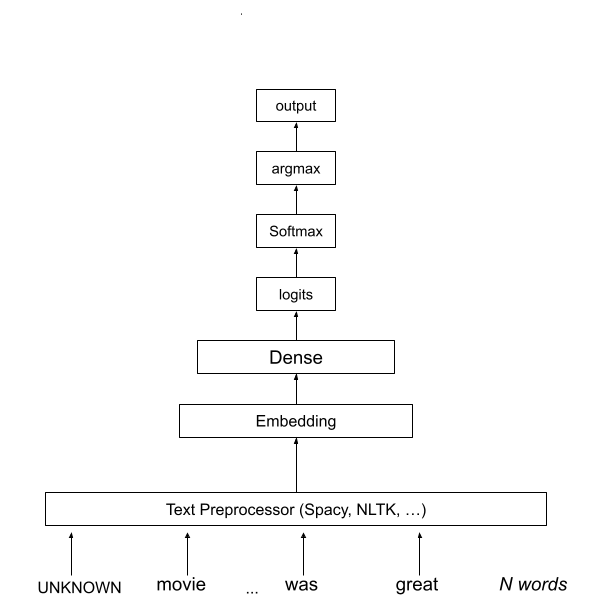




* **Text preprocessor**: this step usually includes preprocessing tasks like transforming to lower case, removing stop words, removing HTML, etc. It has to be carefully designed depending on each use case, as it might have a high impact on the performance of the model.
* **Vectorizer**: the component that given a string of text transforms it into a vector. This is what we call the **embedding** of the text.
* **Classification network**: a neural network that aims to codify the embedding into the output classes. The result of this component is what we call the logits.
* **Model output**: a distribution of probabilities across the classes, usually after applying a sigmoid transformation.


There are **different approaches** for solving this problem. From a very simple approach based on the scikit learn framework to the most advanced **BERT** based model, all of them follow the described architecture. **Differences come in how the embedding is obtained**.

## **Fully Connected Neural Network**

Let's implement a dense neural network for text classification by using word vectors taking the following considerations:

* The input shape is the vector dimension
* The neural network should be composed of  5 `Dense` layers with the following shape: `[500, 300, 250, 100]`
* For the activation functions of intermediate layers you can chose between `tanh` and `relu`.
* `Dropout` is usually used after the activation function to avoid overfitting
* The last dense layer should output a probability value between 0 and 1 for binary classification.

In [ ]:
from keras import regularizers, optimizers
from keras.layers import TextVectorization
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, GlobalMaxPool1D
from keras.models import Sequential
from keras.initializers import Constant
import tensorflow as tf
from keras import layers

# we create a new sequential model object
model = Sequential()

input_shape = vec_dim  #vec_dim=300

## TODO: you can add layers by using model.add(...)
model.add(Input(shape=(input_shape,)))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.output_shape

(None, 1)

Here we are going to define the optimizer, the learning rate and the loss.

The **learning rate** is a hyperparameter used in many machine learning algorithms, such as gradient descent, to control the size of the step taken in the direction of the negative gradient during training. The learning rate determines how quickly the algorithm updates the model's parameters in response to the training data. It should be in the range [0.01, 0.0001].

If the learning rate is too high, the algorithm may not converge and overshoot the optimal solution, while if the learning rate is too low, the algorithm may take too long to converge. A good learning rate balances the trade-off between convergence speed and quality.

Regarding the loss, as we are dealing with a binary classification we are going to use the `"binary_crossentropy"`.

In [ ]:
## TODO set learning rate
adam = optimizers.Adam(learning_rate=0.001, decay=1e-2)

## TODO add loss and optimizer
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               150500    
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 dense_2 (Dense)             (None, 250)               75250     
                                                                 
 dense_3 (Dense)             (None, 100)               25100     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 401,251
Trainable params: 401,251
Non-trainable params: 0
_________________________________________________________________
None


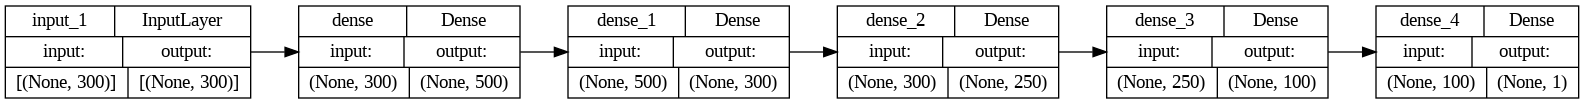

In [ ]:
# show model diagram
plot_model(model, show_shapes=True, rankdir='LR')

In [ ]:
train_data['mean_vector'].shape

(12000,)

In [ ]:
train_data['mean_vector'][0].shape

(300,)

In [ ]:
# Our input data need to have shape [n_samples, features]
mean_vector_array = np.array(train_data['mean_vector'].tolist())
mean_vector_array.shape


(12000, 300)

Fit the data into the model and set the hyperparameters.
* Batch size should be in the range `[32, 250]`
* Epochs should be in the range `[20, 50]`

We are going to use **early stopping** on validation loss for training our network. Early stopping helps prevent overfitting by stopping the training process before the model starts to memorize the training data.

In [ ]:
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

# Our input data need to have shape [n_samples, features]
X_train = np.array(train_data['mean_vector'].tolist())
y_train = train_data['label']

## TODO
history = model.fit(X_train,
          y_train,
          batch_size = 100,
          epochs = 30,
          validation_split=.2,
          callbacks=[earlyStopping],
          shuffle=True)

Epoch 1/30
96/96 [==============================] - 8s 6ms/step - loss: 0.4986 - accuracy: 0.7522 - val_loss: 0.4370 - val_accuracy: 0.7992
Epoch 2/30
96/96 [==============================] - 0s 4ms/step - loss: 0.4252 - accuracy: 0.8058 - val_loss: 0.3983 - val_accuracy: 0.8213
Epoch 3/30
96/96 [==============================] - 0s 4ms/step - loss: 0.4036 - accuracy: 0.8160 - val_loss: 0.4095 - val_accuracy: 0.8108
Epoch 4/30
96/96 [==============================] - 0s 4ms/step - loss: 0.3932 - accuracy: 0.8238 - val_loss: 0.3936 - val_accuracy: 0.8246
Epoch 5/30
96/96 [==============================] - 0s 4ms/step - loss: 0.3744 - accuracy: 0.8347 - val_loss: 0.4279 - val_accuracy: 0.8017
Epoch 6/30
96/96 [==============================] - 0s 4ms/step - loss: 0.3612 - accuracy: 0.8407 - val_loss: 0.4011 - val_accuracy: 0.8175
Epoch 7/30
96/96 [==============================] - 0s 4ms/step - loss: 0.3534 - accuracy: 0.8446 - val_loss: 0.3986 - val_accuracy: 0.8208
Epoch 8/30
96/96 [==

The `"sigmoid"` activation function produces continuous output values between 0 and 1. To convert the predicted values to binary, you can use a threshold value. For example, you can set a threshold of 0.5, such that any predicted value above 0.5 is classified as positive (1) and any predicted value below 0.5 is classified as negative (0). You can use the `round()` function to apply this threshold.

In [ ]:
X_test = np.array(test_data['mean_vector'].tolist())
y_test = test_data['label']

# TODO: Predict labels of test data
y_pred = model.predict(X_test)
y_pred = y_pred.round(2)

threshold = 0.5

y_pred = np.where(y_pred > threshold, 1, 0)
print(y_pred)

125/125 [==============================] - 0s 2ms/step
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
results = model.evaluate(X_test,  y_test)
print(results)

125/125 [==============================] - 0s 2ms/step - loss: 0.4916 - accuracy: 0.7975
[0.491558313369751, 0.7975000143051147]


In [ ]:
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.79725
Precision: 0.8784213876511776
Recall: 0.69


Does it improve the results from the Logistic regression using BoW?

## **Recurrent Neural Network**

Next, we are going to use a LSTM layer into our neural network to learn from long-term dependencies in sequential data.

We need to define a miximum sequence length to batchify our data during training and avoid having a lot of padded texts. To make a good selection you will need to look at the distribution of texts lengths of your data.

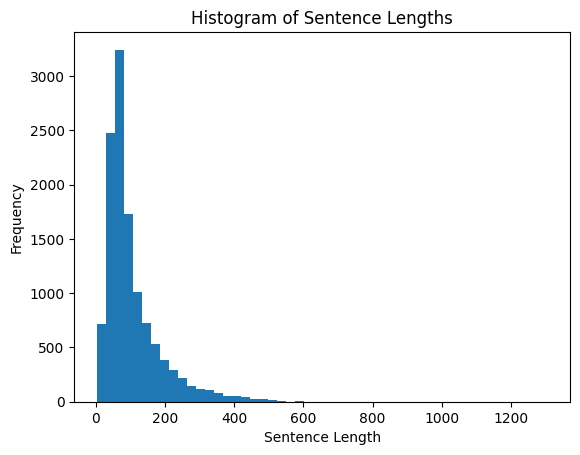

In [ ]:
import matplotlib.pyplot as plt

## TODO: Get lengths of arrays of clean_tokens
sentence_lengths = train_data['clean_tokens'].apply(lambda x: len(x))

# Create a histogram of the sentence lengths
plt.hist(sentence_lengths, bins=50)
plt.title("Histogram of Sentence Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

In [ ]:
sentence_lengths.info()

<class 'pandas.core.series.Series'>
Int64Index: 12000 entries, 5346 to 8280
Series name: clean_tokens
Non-Null Count  Dtype
--------------  -----
12000 non-null  int64
dtypes: int64(1)
memory usage: 445.5 KB


#### Vectorizer

The vocabulary for the layer must be either supplied on construction or learned via `adapt()`. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a vocabulary from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.

The processing of each example contains the following steps:

1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
4. Index tokens (associate a unique int value with each token)
5. Transform each example into a vector of ints using this index

In [ ]:
## TODO: Definition of constants
max_features_vocab = 4000    # Only consider the top X words
embedding_dim = 300          # Dimension of the embedding
seq_length = 90              # Only consider the first X words of each movie review


## TODO: Fill in the ...
Vectorizer = TextVectorization(
    max_tokens=max_features_vocab,
    standardize=None,
    split="whitespace",
    ngrams=None,
    output_mode="int",
    output_sequence_length=seq_length,
    pad_to_max_tokens=False,
    vocabulary=None,
)

In [ ]:
#fit the vectorizer on the clean text and extract the corpus vocabulary
Vectorizer.adapt(train_data['clean_texts'])
vocab = Vectorizer.get_vocabulary()

In [ ]:
len(vocab)

4000

#### Embedding

In [ ]:
#generate the embedding matrix
embedding_matrix = np.zeros((max_features_vocab, embedding_dim))
for i, word in tqdm_notebook(enumerate(vocab)):
    embedding_matrix[i] = nlp(str(word)).vector

0it [00:00, ?it/s]

What is the shape of the embedding matrix?

In [ ]:
## TODO
embedding_matrix.shape

(4000, 300)

Now, let's define the embedding layer with pretrained word vector representation rather than training them. Thus, you need to set trainable to False.

In [ ]:
## TODO: Create an embedding layer instance
# Load the embedding matrix as the weights matrix for the embedding layer
Embedding_layer=tf.keras.layers.Embedding(
    input_dim=max_features_vocab,
    output_dim=embedding_dim,
    weights=[embedding_matrix]
)

#### Add LSTM

Build the recurrent neural network, considering:
* Input dat is a string
* Vectorizes transforms string into ints
* Embedding layer for word representations
* A LSTM layer with 128 units
* Dense layers [64, 32]
* Last layer outputs a value between 0 and 1

In [ ]:
## TODO: Build a neural network with a LSTM
lstm = Sequential()

lstm.add(Input(shape=(1,), dtype=tf.string))
lstm.add(Vectorizer)
lstm.add(Embedding_layer)
lstm.add(LSTM(128))
lstm.add(layers.Dense(64, activation='relu'))
lstm.add(layers.Dense(32, activation='relu'))
lstm.add(layers.Dense(1, activation='sigmoid'))

print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 90)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 90, 300)           1200000   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                      

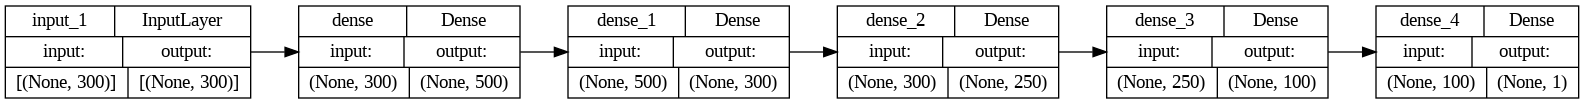

In [ ]:
plot_model(model, show_shapes=True, rankdir='LR')

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

X_train = train_data['clean_texts']
y_train = train_data['label']

lstm.fit(X_train,
          y_train,
          batch_size = 100,
          epochs = 30,
          validation_split=.2,
          callbacks=[earlyStopping],
          shuffle=True)

Epoch 1/30
96/96 [==============================] - 23s 190ms/step - loss: 0.6284 - accuracy: 0.6274 - val_loss: 0.5191 - val_accuracy: 0.7542
Epoch 2/30
96/96 [==============================] - 11s 112ms/step - loss: 0.4474 - accuracy: 0.8018 - val_loss: 0.4349 - val_accuracy: 0.7979
Epoch 3/30
96/96 [==============================] - 7s 74ms/step - loss: 0.3577 - accuracy: 0.8543 - val_loss: 0.4303 - val_accuracy: 0.8075
Epoch 4/30
96/96 [==============================] - 6s 62ms/step - loss: 0.2765 - accuracy: 0.8901 - val_loss: 0.4481 - val_accuracy: 0.8079
Epoch 5/30
96/96 [==============================] - 5s 49ms/step - loss: 0.2068 - accuracy: 0.9242 - val_loss: 0.4525 - val_accuracy: 0.8150
Epoch 6/30
96/96 [==============================] - 3s 32ms/step - loss: 0.1512 - accuracy: 0.9485 - val_loss: 0.6051 - val_accuracy: 0.8087
Epoch 7/30
96/96 [==============================] - 4s 40ms/step - loss: 0.1351 - accuracy: 0.9550 - val_loss: 0.6177 - val_accuracy: 0.8025
Epoch 8/3

In [ ]:
## TODO: Get predictions from your trained network and compute performance metrics
X_test = test_data['clean_texts']

y_pred = lstm.predict(X_test)
y_pred = y_pred.round(2)

threshold = 0.5
y_pred = np.where(y_pred > threshold, 1, 0)
print(y_pred)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

125/125 [==============================] - 1s 4ms/step
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
Accuracy: 0.7935
Precision: 0.8618988902589396
Recall: 0.699


We achieved a better performance than Dense Neural Network with half of the parameters!

## Bidirectional LSTM

Bidirectional LSTMs are an extension of LSTMs. The basic idea behind a bidirectional LSTM is to run two separate LSTM layers on the input sequence, one in the forward direction and one in the backward direction. This allows the network to capture information from both past and future contexts of each input element, and combine them to make better predictions.

Let's implement a neural network with a bidirectional LSTM layer of 64 units and compare the performance with previous networks.

In [ ]:
from keras.layers import Bidirectional

In [ ]:
## TODO: Implement a neural network with a bidirectional LSTM
bi_lstm = Sequential()

bi_lstm.add(Input(shape=(1,), dtype=tf.string))
bi_lstm.add(Vectorizer)
bi_lstm.add(Embedding_layer)
bi_lstm.add(Bidirectional(layer=LSTM(64)))
bi_lstm.add(layers.Dense(64, activation='relu'))
bi_lstm.add(layers.Dense(32, activation='relu'))
bi_lstm.add(layers.Dense(1, activation='sigmoid'))

print(bi_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 90)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 90, 300)           1200000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                

In [ ]:
## TODO: Fit the model
bi_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

X_train = train_data['clean_texts']
y_train = train_data['label']

bi_lstm.fit(X_train,
          y_train,
          batch_size = 100,
          epochs = 30,
          validation_split=.2,
          callbacks=[earlyStopping],
          shuffle=True)

Epoch 1/30
96/96 [==============================] - 20s 161ms/step - loss: 0.5781 - accuracy: 0.6814 - val_loss: 0.4573 - val_accuracy: 0.7892
Epoch 2/30
96/96 [==============================] - 9s 91ms/step - loss: 0.3818 - accuracy: 0.8314 - val_loss: 0.4035 - val_accuracy: 0.8146
Epoch 3/30
96/96 [==============================] - 7s 78ms/step - loss: 0.2823 - accuracy: 0.8821 - val_loss: 0.4094 - val_accuracy: 0.8221
Epoch 4/30
96/96 [==============================] - 4s 38ms/step - loss: 0.1896 - accuracy: 0.9272 - val_loss: 0.4755 - val_accuracy: 0.8171
Epoch 5/30
96/96 [==============================] - 4s 42ms/step - loss: 0.1233 - accuracy: 0.9565 - val_loss: 0.5281 - val_accuracy: 0.8179
Epoch 6/30
96/96 [==============================] - 4s 35ms/step - loss: 0.0729 - accuracy: 0.9760 - val_loss: 0.6266 - val_accuracy: 0.8208
Epoch 7/30
96/96 [==============================] - 3s 26ms/step - loss: 0.0443 - accuracy: 0.9870 - val_loss: 0.7661 - val_accuracy: 0.8071


In [ ]:
## TODO: Predict with a test dataset
y_pred = bi_lstm.predict(X_test)
y_pred = y_pred.round(2)

threshold = 0.5
y_pred = np.where(y_pred > threshold, 1, 0)
print(y_pred)


# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

125/125 [==============================] - 1s 5ms/step
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]
Accuracy: 0.79175
Precision: 0.8336192109777015
Recall: 0.729


## BERT classifier
Finally, in our text classification examples, we will show how to use a Transformer model, in this case BERT. From the encoder/decoder tuple, we will use only the encoder component to obtain a proper semantic representation of the reviews.
With this Embedding we then apply the usual dense layer for learning the classifier for our particular application.
In this example, we also take advantage to show how to use the Tensorflow data framework for dealing with heavy datasets if required.

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 31.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

As one can see, the model, after including our BERT layer is quite simple, as the representation obtained using the pretrained model is good enough to learn the language and it only needs some adjustment to learn the concrete classification problem.

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
bert_classifier_model = build_classifier_model()

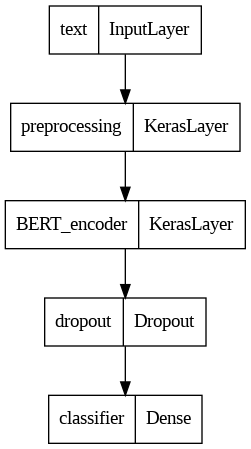

In [ ]:
tf.keras.utils.plot_model(bert_classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics_binAcc = tf.metrics.BinaryAccuracy()

Here we use the dataset framework from tensorflow as it is needed by the pretrained hub models.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32 #se der erro, mudar de 64 para 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
bert_classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics_binAcc)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = bert_classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/2


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


625/625 [==============================] - 750s 1s/step - loss: 0.4889 - binary_accuracy: 0.7607 - val_loss: 0.3923 - val_binary_accuracy: 0.8164
Epoch 2/2
625/625 [==============================] - 727s 1s/step - loss: 0.2758 - binary_accuracy: 0.8864 - val_loss: 0.3670 - val_binary_accuracy: 0.8514


In [ ]:
# Evaluate with test dataset
bert_classifier_model.evaluate(test_ds)

782/782 [==============================] - 301s 385ms/step - loss: 0.3573 - binary_accuracy: 0.8536


[0.3572671115398407, 0.853600025177002]

In [ ]:
predicted = bert_classifier_model.predict(test_data['text'])

# Model Accuracy
y_test = test_data.label
y_pred = predicted.reshape(-1).round()

print("BERT Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("BERT Precision:",metrics.precision_score(y_test, y_pred))
print("BERT Recall:",metrics.recall_score(y_test, y_pred))

125/125 [==============================] - 48s 377ms/step
BERT Accuracy: 0.86225
BERT Precision: 0.8432022738038845
BERT Recall: 0.89
